In [1]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

In [2]:
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
# disable_progress_bar controls the visibility of progress bars
from torch.utils.data import DataLoader
import flwr
from flwr_datasets import FederatedDataset

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.18.0 / PyTorch 2.6.0+cu124


In [4]:
NUM_CLIENTS = 10
BATCH_SIZE = 32

In [13]:
from flwr_datasets.partitioner import DirichletPartitioner

# alpha=10 (iid), alpha=(0,1/0.3) noniid; alpha=0.01 (extreme noniid)
partitioner = DirichletPartitioner(num_partitions=NUM_CLIENTS,alpha=0.05,partition_by="label",seed=42)

In [14]:
# partition_id refers to client (0-9)
def load_datasets(partition_id: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": partitioner}) #fds will contain the federated version of the CIFAR-10
    partition = fds.load_partition(partition_id)
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize(mean,std_dev)
        ]
    )

    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]] #batch["img"] refers to list of images
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)

    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True # Retrieve training partition of the dataset from partition_train_test
    )
    valloader = DataLoader(
        partition_train_test["test"], batch_size=BATCH_SIZE
    )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(
        testset, batch_size=BATCH_SIZE
    )
    return trainloader, valloader, testloader

In [15]:
from collections import Counter

NUM_CLIENTS = 10
NUM_CLASSES = 10

total_counts_client_class = np.zeros((NUM_CLASSES, NUM_CLIENTS)) # (10*10)
for client_id in range(NUM_CLIENTS):
    trainloader, _, _ = load_datasets(client_id)
    label_list = []
    for batch in trainloader:
        labels = batch["label"] # 32 sized tensor and converting it into list by labels.tolist() & appending it to label_list
        label_list.extend(labels.tolist())
    class_counts = Counter(label_list)
    # Counter(label_list) is a dictionary to store one client has how many objects of 10 classes
    for cls in range(NUM_CLASSES):
        total_counts_client_class[cls][client_id] = class_counts.get(cls, 0)

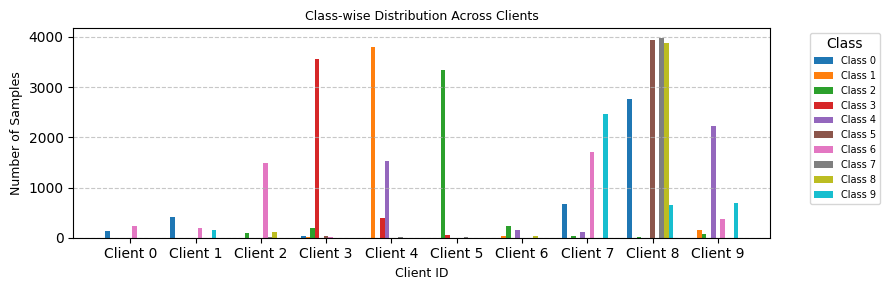

In [16]:
x=np.arange(NUM_CLIENTS)
bar_width=0.07

plt.figure(figsize=(9,3))

for cls in range(NUM_CLASSES):
    plt.bar(x+cls*bar_width,total_counts_client_class[cls],width=bar_width,label=f'Class {cls}')

plt.xlabel("Client ID", fontsize=9)
plt.ylabel("Number of Samples", fontsize=9)
plt.title("Class-wise Distribution Across Clients", fontsize=9)
plt.xticks(x+bar_width*NUM_CLASSES/2, [f"Client {i}" for i in range(NUM_CLIENTS)])
plt.legend(title="Class",bbox_to_anchor=(1.05,1),loc="upper left",fontsize=7)
plt.grid(axis='y',linestyle='--',alpha=0.7)
plt.tight_layout()
plt.show()